In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

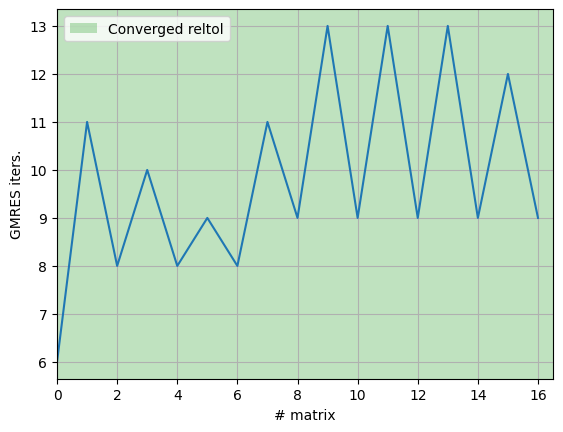

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [3]:
mat_idx = 14
# mat_idx = 8
get_gmres_iterations(data)[mat_idx]

9

In [4]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open[mat_idx])

8 0 160


In [5]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [6]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 0.86


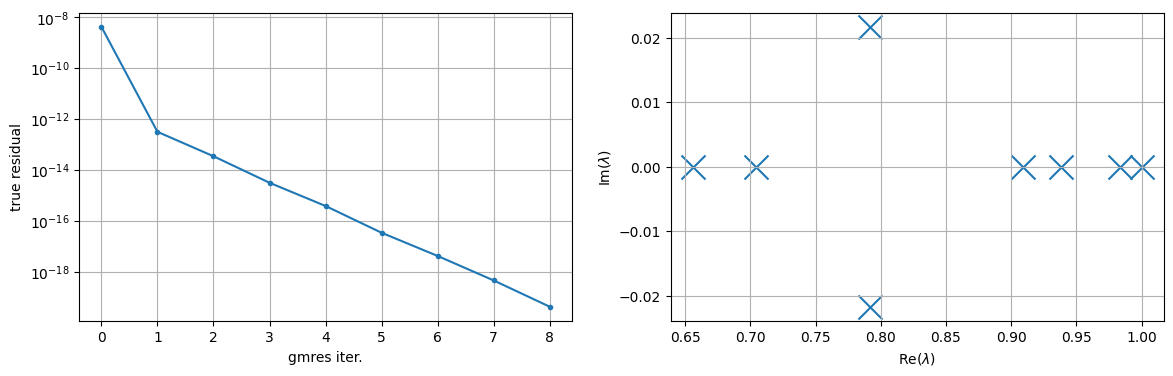

In [7]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

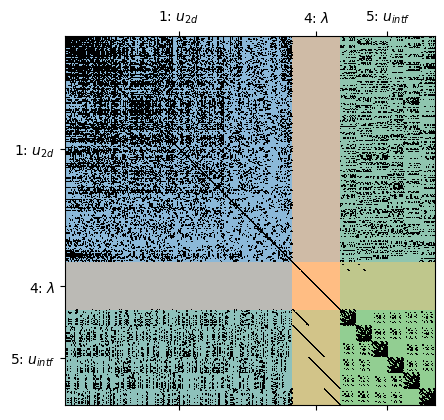

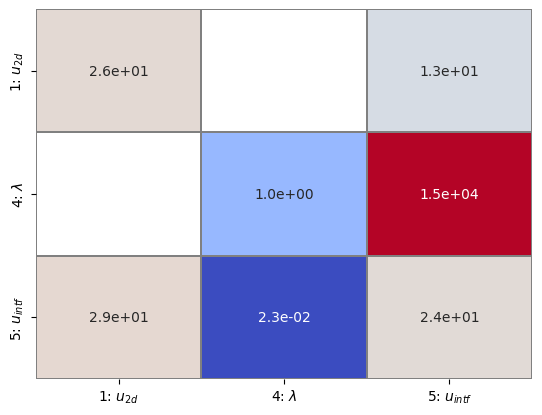

In [9]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    global_row_idx=corrected_eq_dofs,
    global_col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[1, 4, 5]].color_spy()

# J[:].color_spy()
J[[1,4,5]].plot_max()
# J[:].matshow()

Solve  took: 0.12


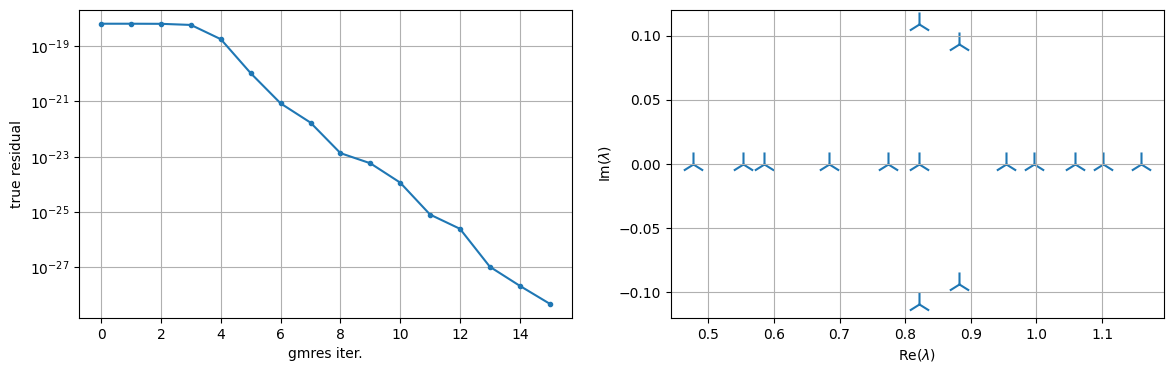

In [14]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv

schema15_amg = SolveSchema(
    groups=[1,5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv(model=model, bmat=J),
    complement=schema15_amg,
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))

Solve  took: 1.13


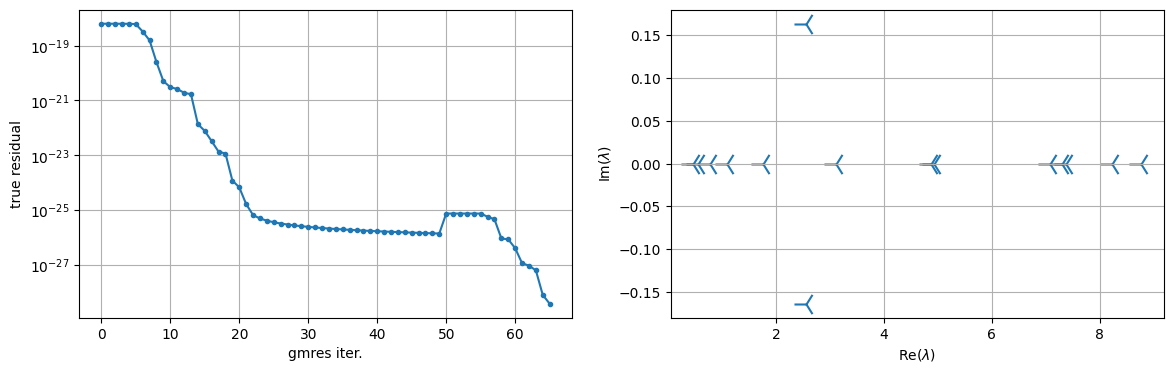

In [15]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_J44_inv

schema = SolveSchema(
    groups=[1, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    invertor=lambda bmat: inv_block_diag(diag_nd(bmat.mat, nd=model.nd), nd=model.nd),
    # only_complement=True,
    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: make_J44_inv(model=model, bmat=J),
    ),
)
mat_permuted, prec_good = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec_good, mat_permuted.local_rhs(rhs))